## 自己組織化マップ（SOM)＆クラスタリング 2

絵画に使われている色を、先に作った自己組織化マップのプログラムで解析している。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
% matplotlib notebook
import urllib.request
import io
import PIL.Image
import cv2

# ネット上の画像を取ってくるメソッド
def url2img(url):
    print(url)
    f = io.BytesIO(urllib.request.urlopen(url).read())
    img = PIL.Image.open(f)
    imgArray = np.asarray(img)
    return imgArray

# 画像から　色を　num 個ピックアップするメソッド
def pickcolor(imgArray, num):
    w = imgArray.shape[1]
    h = imgArray.shape[0]
    ret = []
    for i in range(num):
        rw = int(w*np.random.rand())
        rh = int(h*np.random.rand())
        ret.append(imgArray[rh,rw]/255)
    return ret

In [2]:
import scipy.stats as st
# ガウス分布
def gkern(kernlen=21, nsig=3):
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

# 自己組織化マップ SOM を生成する　　　　M :２次元配置されたニューロンの重み配列    x : 入力データ,  alpha：学習係数
def organize_som(M, x, alpha=0.3, ksize=3):
    gk = gkern(2*ksize+1,ksize)/np.max(gkern(2*ksize+1,ksize))
    mini, minj = get_winner(M,x)
    MM = np.zeros((M.shape[0]+2*ksize, M.shape[1]+2*ksize,3),np.float64)
    MM[ksize:-ksize,ksize:-ksize]=M
    for i in range(-ksize,ksize+1): #  勝者の近傍7x7 の範囲を与えられたデータ（このプログラムでは色）に近づける
        for j in range(-ksize,ksize+1):
            try:
                MM[ksize+mini+i,ksize+minj+j] += alpha * (x - MM[ksize+mini+i,ksize+minj+j])*gk[ksize+i,ksize+j]
            except:
                pass
    return MM[ksize:-ksize,ksize:-ksize]

def show_som(M):
    im = plt.imshow(M,interpolation='nearest',origin='lower')
    return im

# Map M において、ベクトルｘともっとも近い重みベクトルを持つノードの座標を得る
def get_winner(M,x):
    col =  M.shape[1]
    # row =  M.shape[0]
    min_i = np.argmin(((M-x)**2).sum(axis=2)) 
    mini = min_i // col # argmin は1次元化した番号が返ってくるので　2次元化
    minj = min_i % col
    return mini, minj

# 配列３次元M（ただし最後の次元は３要素でありカラーデータとみなせるもの）を matplot 画像データとして返す
def show_som(M):
    im = plt.imshow(M,interpolation='none',origin='lower')
    return im

In [3]:
from sklearn.cluster import KMeans

def kmeans(M,k,itr):   # 配列Mの要素を対象として k-Means 法でクラスタリングを実行する　　k クラスタ数、 itr 繰り返し処理回数
    row = M.shape[0]
    col = M.shape[1]
    ch = M.shape[2]
    data = M.reshape(col*row,ch)
    km = KMeans(n_clusters=k,init='random',n_init=1,max_iter=itr,random_state=1)
    labelimage = (km.fit(data).labels_).reshape(row,col)
    centers = km.cluster_centers_
    return labelimage, centers 

from matplotlib.colors import LinearSegmentedColormap
# カスタムカラーマップの生成
def generate_cmap(centers):
    lebels = len(centers)
    values = range(lebels)
    color_list = centers # ３次元データの重心の値そのものをカラーデータとみなす
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

# 境界の描画
def plotBoundary(labels, somcenters, cmap='tab20', colorbar=True):
    row = labels.shape[0]
    col = labels.shape[1]
    
    YY,XX = np.mgrid[0:row, 0:col] # make a grid    
    
    plt.pcolormesh(XX, YY, labels, cmap=cmap,zorder=-10) 
    
    if colorbar:
        plt.colorbar()
        
    for index, p in enumerate(somcenters):
        plt.text(p[1],p[0],str(index),ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.3, lw=0))

ウェブ上の画像をカラーデータの採取用に読み込む

http://bokyo-qualia.com/wp-content/uploads/2017/03/7-A-Girl-with-Pearl-Earring-e1490951233682.jpg


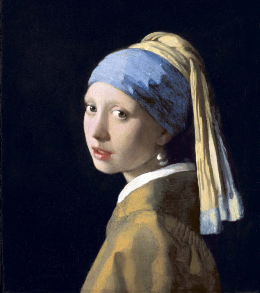

In [4]:
# 真珠の耳飾の少女（A Girl with Pearl Earring）1665年　フェルメール
imgArray = url2img("http://bokyo-qualia.com/wp-content/uploads/2017/03/7-A-Girl-with-Pearl-Earring-e1490951233682.jpg")
img = PIL.Image.fromarray(imgArray)
img.resize(np.array(img.size)//2)

<IPython.core.display.Javascript object>


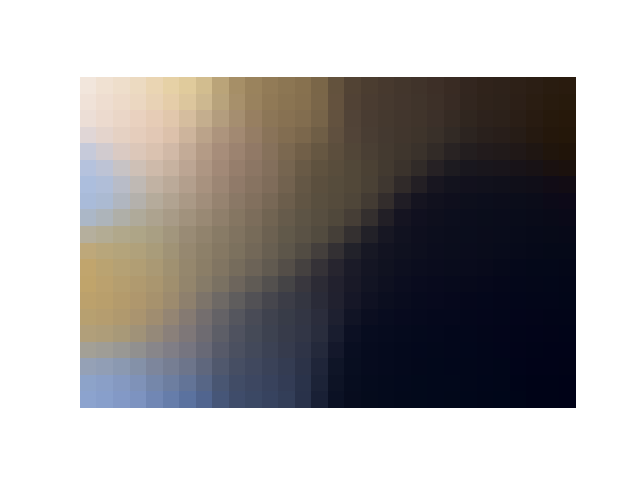

In [5]:
# メインプログラム
row = 20  # 高さ
col = 30 # 幅
learntime = 256 # 繰り返し学習回数
batchsize = 128 # １回の繰り返しで採取するデータの数
alpha = 0.3 # 学習係数

W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    pcolors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in pcolors:
        W=organize_som(W, color,alpha=alpha,ksize=3) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
plt.show()

[(12, 14), (10, 10), (17, 26), (15, 3), (12, 22), (7, 26), (13, 18), (17, 8), (6, 6), (2, 9), (2, 1), (9, 16)]


<IPython.core.display.Javascript object>


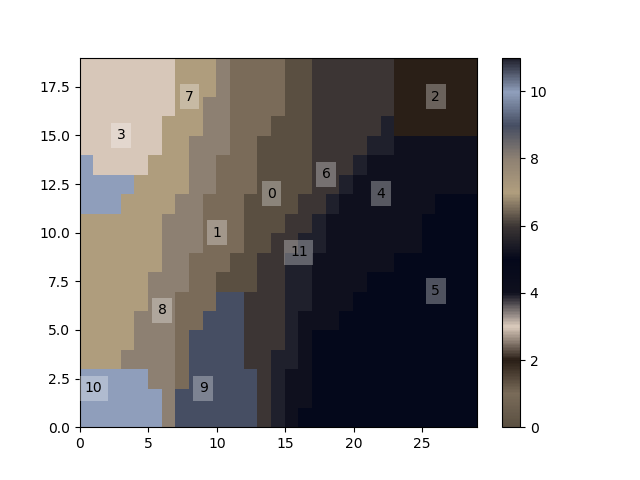

In [6]:
# 代表色12
labelimage, centers = kmeans(W,12,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

http://bokyo-qualia.com/wp-content/uploads/2017/03/5-The-Scream-e1490952692280.jpg


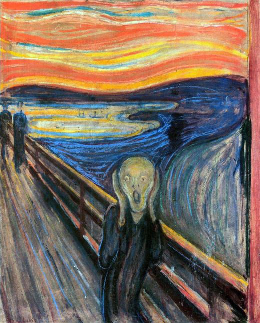

In [7]:
# 叫び（The Scream）1893年　エドヴァルド・ムンク
imgArray = url2img("http://bokyo-qualia.com/wp-content/uploads/2017/03/5-The-Scream-e1490952692280.jpg")
img = PIL.Image.fromarray(imgArray)
img.resize(np.array(img.size)//2)

<IPython.core.display.Javascript object>


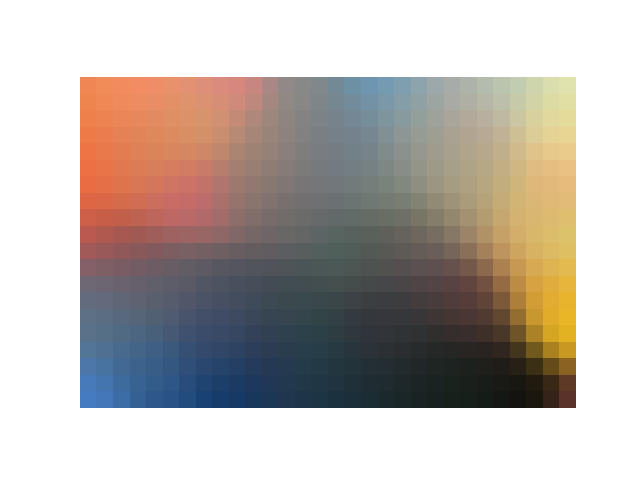

In [8]:
W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    pcolors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in pcolors:
        W=organize_som(W, color,alpha=alpha,ksize=3) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
plt.show()

[(16, 22), (11, 12), (17, 27), (17, 1), (8, 19), (3, 22), (18, 13), (15, 7), (3, 3), (3, 12), (10, 4), (11, 27)]


<IPython.core.display.Javascript object>


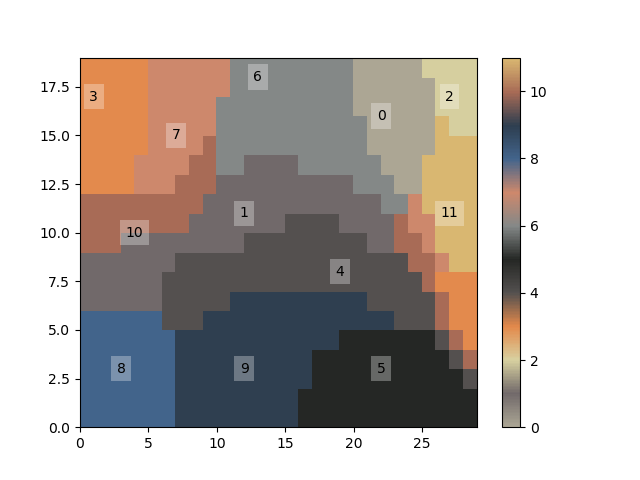

In [9]:
# 代表色12
labelimage, centers = kmeans(W,12,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters,cmap=custom_cmap)

http://bokyo-qualia.com/wp-content/uploads/2017/03/3-Starry-Night-e1490953303227.jpg


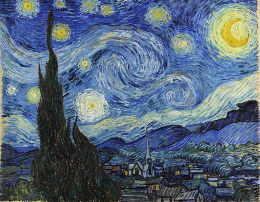

In [10]:
# 星月夜（The starry night）1889年　ヴィンセント・ヴァン・ゴッホ
imgArray = url2img("http://bokyo-qualia.com/wp-content/uploads/2017/03/3-Starry-Night-e1490953303227.jpg")
img = PIL.Image.fromarray(imgArray)
img.resize(np.array(img.size)//2)

<IPython.core.display.Javascript object>


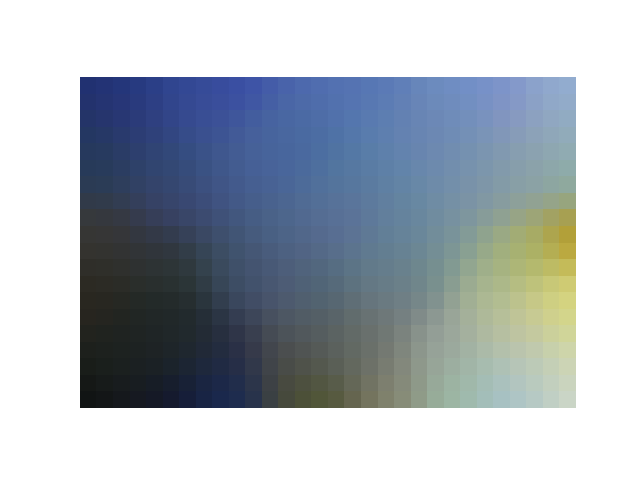

In [11]:
W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    pcolors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in pcolors:
        W=organize_som(W, color,alpha=alpha,ksize=3) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
plt.show()

[(2, 21), (14, 15), (16, 26), (14, 4), (5, 19), (3, 27), (14, 21), (14, 9), (4, 5), (5, 15), (3, 10), (9, 27)]


<IPython.core.display.Javascript object>


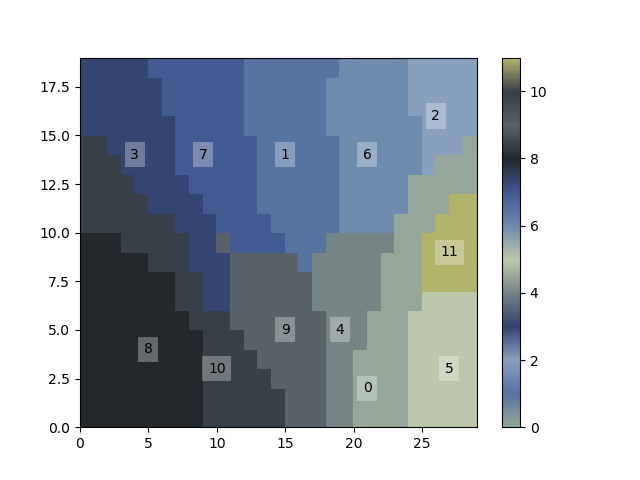

In [12]:
# 代表色12
labelimage, centers = kmeans(W,12,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters,cmap=custom_cmap)

http://bokyo-qualia.com/wp-content/uploads/2017/03/mona_lisa-1.jpg


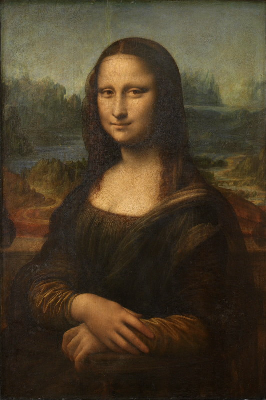

In [13]:
# モナ・リザ（Mona Lisa）1503～1519年頃　レオナルド・ダ・ヴィンチ
imgArray = url2img("http://bokyo-qualia.com/wp-content/uploads/2017/03/mona_lisa-1.jpg")
img = PIL.Image.fromarray(imgArray)
img.resize(np.array(img.size)//2)

<IPython.core.display.Javascript object>


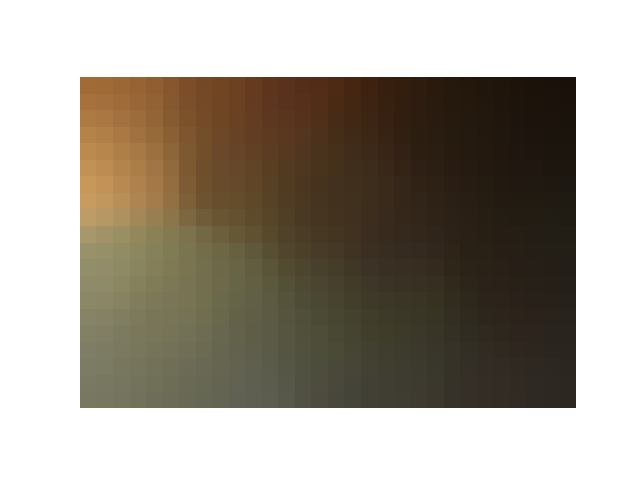

In [14]:
W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    pcolors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in pcolors:
        W=organize_som(W, color,alpha=alpha,ksize=3) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
plt.show()

[(11, 23), (15, 12), (15, 26), (17, 3), (4, 13), (6, 16), (9, 21), (15, 7), (6, 3), (4, 8), (12, 2), (10, 17)]


<IPython.core.display.Javascript object>


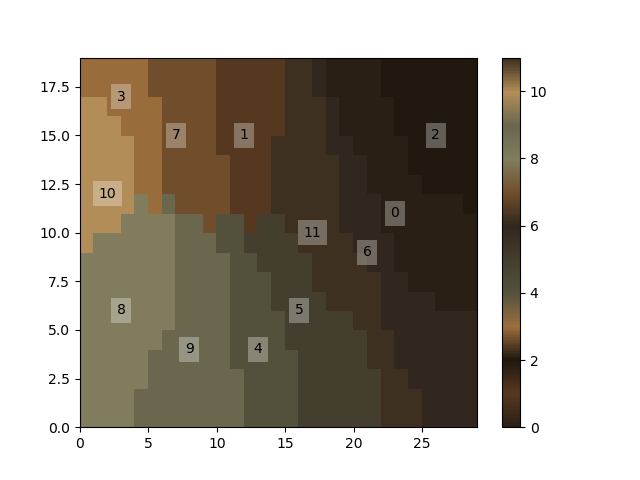

In [15]:
# 代表色12
labelimage, centers = kmeans(W,12,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

http://bokyo-qualia.com/wp-content/uploads/2017/03/8-Water-Lilies-e1490950846969.jpg


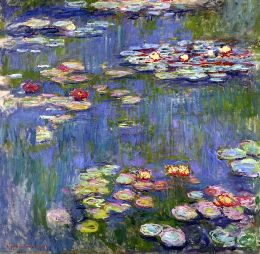

In [16]:
# 睡蓮（Water Lilies）1916年　クロード・モネ
imgArray = url2img("http://bokyo-qualia.com/wp-content/uploads/2017/03/8-Water-Lilies-e1490950846969.jpg")
img = PIL.Image.fromarray(imgArray)
img.resize(np.array(img.size)//2)

<IPython.core.display.Javascript object>


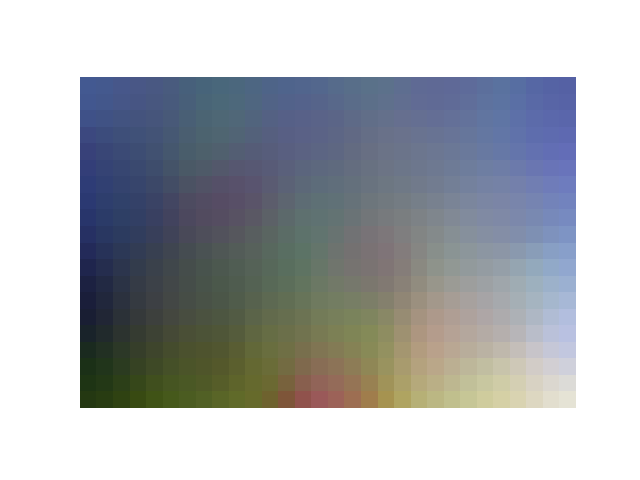

In [17]:
W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    pcolors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in pcolors:
        W=organize_som(W, color,alpha=alpha,ksize=3) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
plt.show()

[(12, 26), (10, 15), (18, 23), (4, 9), (2, 21), (2, 27), (10, 21), (15, 10), (3, 2), (2, 16), (11, 4), (7, 26)]


<IPython.core.display.Javascript object>


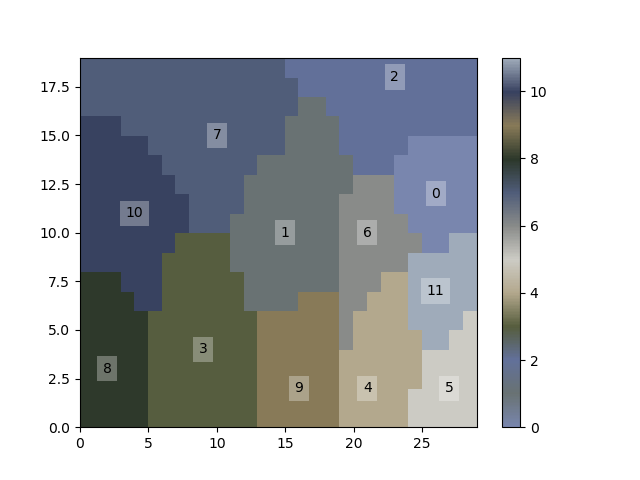

In [18]:
# 代表色12
labelimage, centers = kmeans(W,12,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

[(15, 26), (10, 13), (18, 27), (9, 8), (3, 21), (2, 24), (10, 22), (15, 9), (2, 8), (4, 13), (8, 3), (9, 28), (3, 1), (16, 20), (6, 24), (2, 18), (2, 27), (10, 18), (12, 3), (15, 14), (1, 15), (17, 2), (6, 28), (12, 27)]


<IPython.core.display.Javascript object>


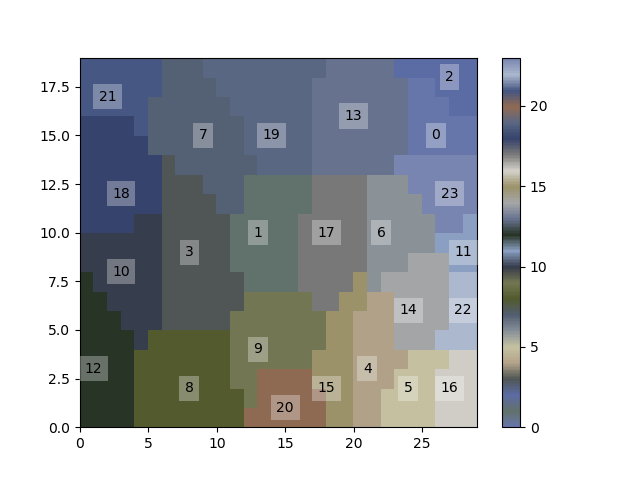

In [19]:
# 代表色24
labelimage, centers = kmeans(W,24,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

http://bokyo-qualia.com/wp-content/uploads/2017/03/10-Birth-of-Venus-e1490950331409.jpg


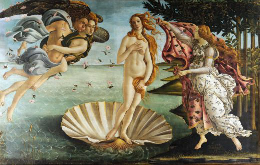

In [20]:
# ヴィーナスの誕生（Birth of Venus）1486年　ボッティチェルリ
imgArray = url2img("http://bokyo-qualia.com/wp-content/uploads/2017/03/10-Birth-of-Venus-e1490950331409.jpg")
img = PIL.Image.fromarray(imgArray)
img.resize(np.array(img.size)//2)

<IPython.core.display.Javascript object>


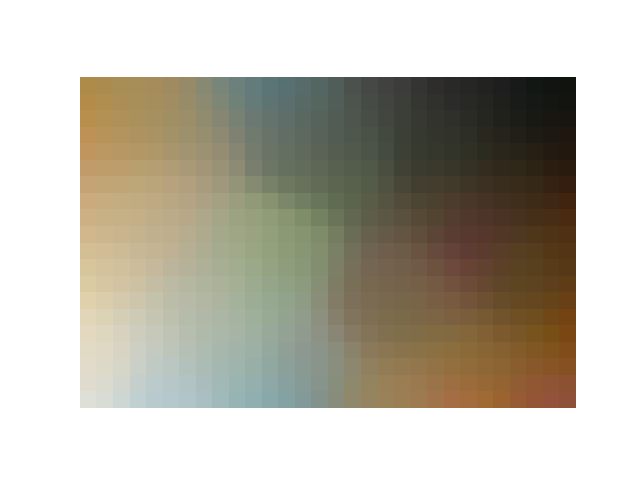

In [21]:
W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    pcolors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in pcolors:
        W=organize_som(W, color,alpha=alpha,ksize=3) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
plt.show()

[(14, 23), (15, 13), (16, 27), (15, 3), (4, 24), (3, 20), (14, 18), (5, 12), (3, 3), (19, 7), (8, 5), (8, 26)]


<IPython.core.display.Javascript object>


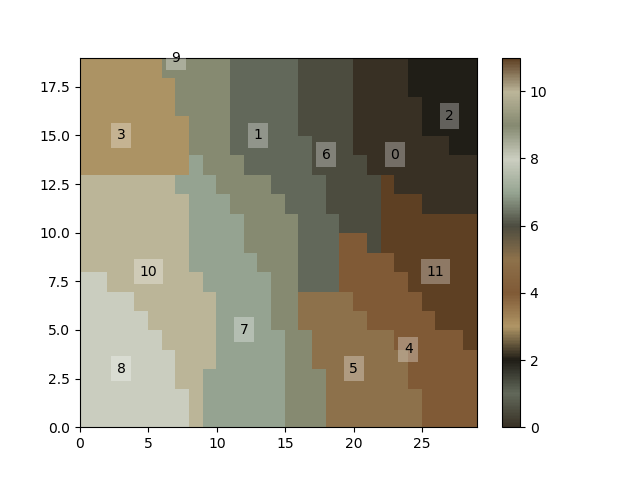

In [22]:
# 代表色12
labelimage, centers = kmeans(W,12,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

[(15, 26), (16, 11), (17, 27), (6, 13), (1, 26), (2, 21), (12, 23), (14, 9), (3, 7), (4, 16), (9, 3), (7, 28), (3, 2), (17, 18), (8, 21), (6, 18), (4, 27), (16, 22), (13, 4), (15, 15), (4, 11), (17, 3), (10, 21), (11, 27)]


<IPython.core.display.Javascript object>


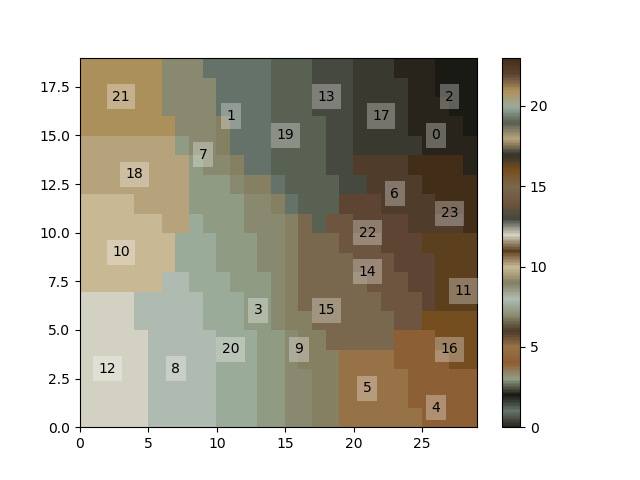

In [23]:
# 代表色24
labelimage, centers = kmeans(W,24,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

https://i.pinimg.com/originals/83/e6/d1/83e6d1bedb21cab67279baa632cbe799.jpg


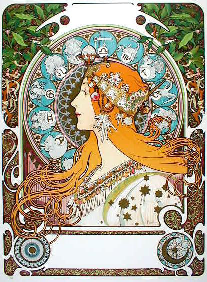

In [24]:
# アルフォンス・ミュシャ
imgArray = url2img("https://i.pinimg.com/originals/83/e6/d1/83e6d1bedb21cab67279baa632cbe799.jpg")
img = PIL.Image.fromarray(imgArray)
img.resize(np.array(img.size)//2)

<IPython.core.display.Javascript object>


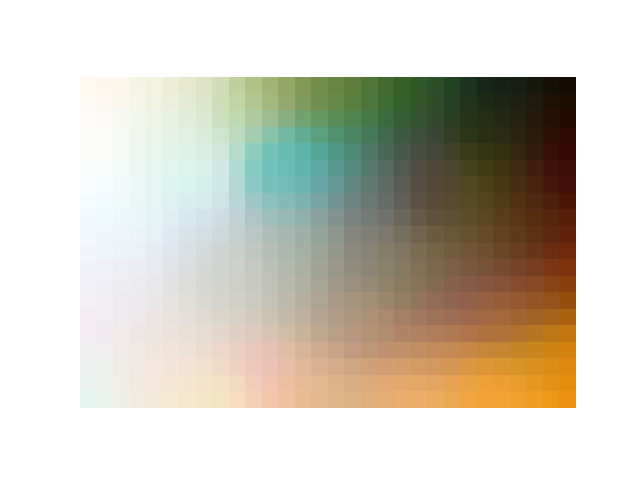

In [25]:
W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    pcolors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in pcolors:
        W=organize_som(W, color,alpha=alpha,ksize=3) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
plt.show()

[(10, 26), (12, 13), (16, 26), (5, 6), (10, 18), (2, 26), (15, 20), (8, 11), (2, 12), (3, 17), (2, 0), (6, 25)]


<IPython.core.display.Javascript object>


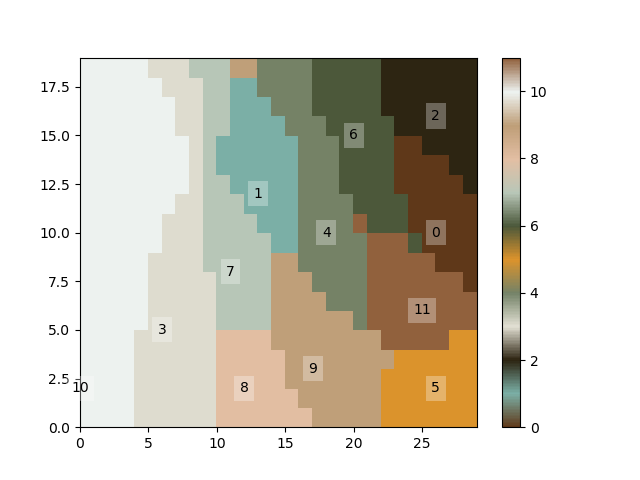

In [26]:
# 代表色１２
labelimage, centers = kmeans(W,12,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

[(13, 28), (13, 13), (18, 28), (9, 8), (5, 23), (2, 20), (11, 22), (9, 11), (3, 10), (6, 14), (0, 1), (9, 28), (3, 5), (17, 19), (9, 21), (8, 17), (2, 27), (17, 23), (9, 0), (14, 17), (1, 14), (18, 2), (6, 28), (13, 25)]


<IPython.core.display.Javascript object>


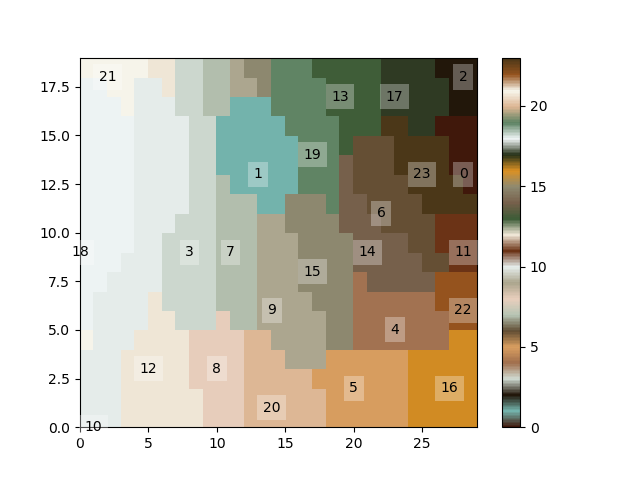

In [27]:
# 代表色24
labelimage, centers = kmeans(W,24,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

http://pds.exblog.jp/pds/1/201402/06/28/d0240728_18362623.jpg


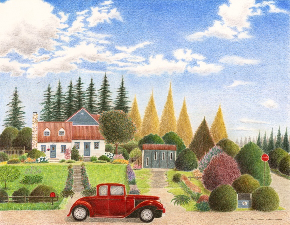

In [28]:
# Mikako Watanabe
imgArray = url2img("http://pds.exblog.jp/pds/1/201402/06/28/d0240728_18362623.jpg")
img = PIL.Image.fromarray(imgArray)
img.resize(np.array(img.size)//2)

<IPython.core.display.Javascript object>


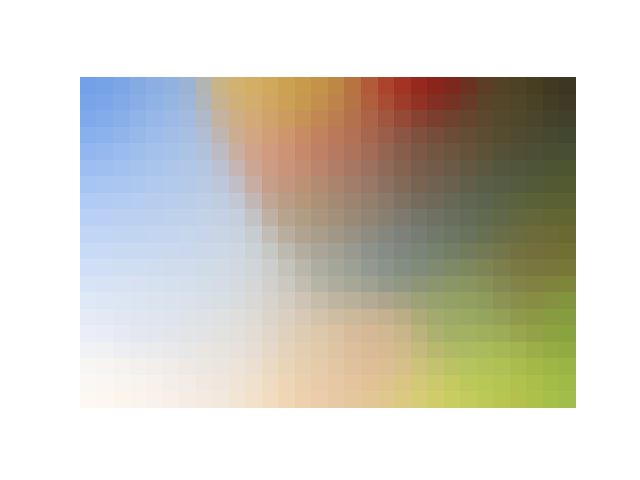

In [29]:
# メインプログラム
row = 20  # 高さ
col = 30 # 幅
learntime = 512 # 繰り返し学習回数
batchsize = 256 # １回の繰り返しで採取するデータの数
alpha = 0.1 # 学習係数

W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    pcolors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in pcolors:
        W=organize_som(W, color,alpha=alpha,ksize=3) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
plt.show()

[(10, 26), (16, 14), (17, 26), (17, 4), (7, 19), (3, 24), (8, 24), (5, 18), (3, 6), (5, 13), (11, 7), (17, 19)]


<IPython.core.display.Javascript object>


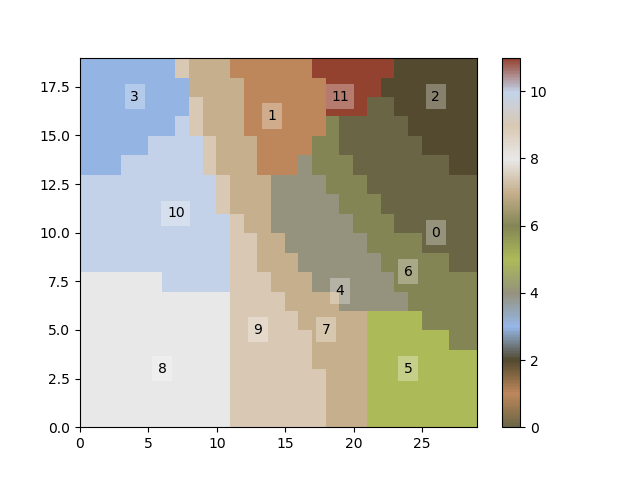

In [30]:
# 代表色12
labelimage, centers = kmeans(W,12,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

[(15, 26), (17, 12), (18, 27), (13, 5), (5, 22), (2, 24), (13, 21), (3, 19), (5, 7), (7, 13), (9, 6), (8, 27), (2, 4), (18, 20), (11, 17), (6, 18), (4, 27), (17, 22), (17, 5), (16, 16), (3, 13), (18, 2), (12, 19), (11, 26)]


<IPython.core.display.Javascript object>


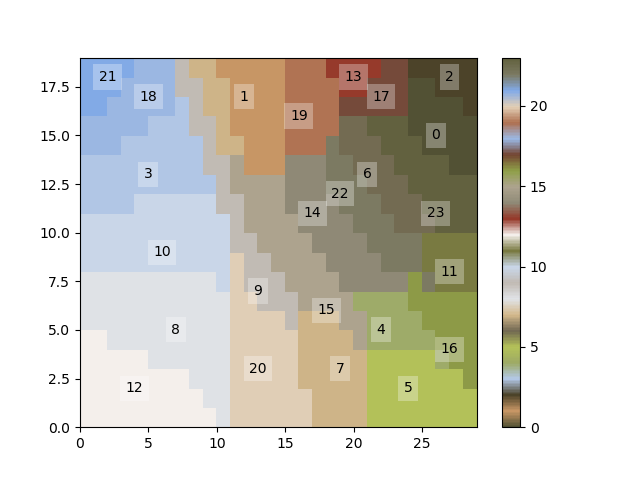

In [31]:
# 代表色24
labelimage, centers = kmeans(W,24,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

[(15, 26), (17, 14), (18, 27), (14, 4), (5, 22), (2, 25), (13, 22), (6, 17), (2, 9), (5, 17), (12, 5), (9, 27), (1, 3), (18, 20), (7, 24), (10, 15), (4, 27), (16, 21), (16, 3), (16, 17), (2, 13), (18, 2), (6, 27), (12, 27), (11, 18), (18, 6), (9, 12), (1, 17), (14, 8), (7, 5), (14, 12), (10, 7), (4, 3), (6, 11), (2, 21), (12, 20)]


<IPython.core.display.Javascript object>


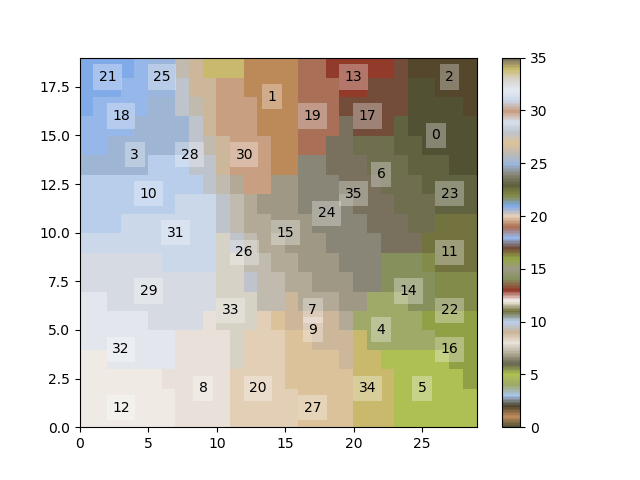

In [32]:
# 代表色36
labelimage, centers = kmeans(W,36,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

[(14, 25), (13, 14), (17, 27), (16, 6), (5, 23), (1, 23), (12, 23), (4, 19), (4, 8), (5, 16), (10, 2), (10, 27), (1, 2), (17, 22), (7, 21), (4, 21), (4, 27), (15, 22), (16, 2), (17, 16), (1, 13), (18, 0), (8, 27), (11, 27), (10, 19), (16, 4), (12, 10), (2, 17), (7, 13), (6, 5), (14, 10), (8, 4), (5, 2), (7, 9), (18, 10), (11, 21), (1, 8), (17, 24), (17, 2), (15, 27), (11, 8), (6, 27), (13, 29), (4, 13), (1, 20), (11, 14), (7, 18), (14, 8), (2, 27), (14, 3), (14, 13), (8, 11), (2, 11), (18, 13), (18, 28), (18, 19), (18, 5), (2, 15), (1, 5), (13, 5), (17, 15), (15, 19), (3, 2), (7, 24), (9, 14), (19, 21), (0, 17), (14, 11), (17, 18), (18, 7), (13, 17), (11, 11)]


<IPython.core.display.Javascript object>


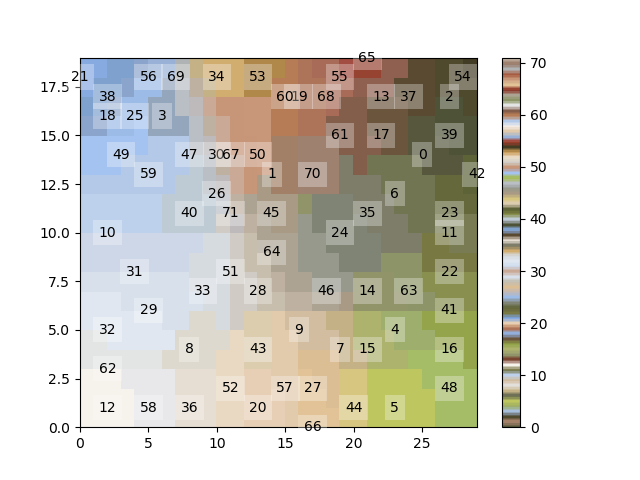

In [33]:
# 代表色72
labelimage, centers = kmeans(W,72,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)

In [34]:
ani.save("mi.mp4")